# Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import (cross_val_score, 
                                     StratifiedKFold, 
                                     GridSearchCV)

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (confusion_matrix, 
                             ConfusionMatrixDisplay, 
                             classification_report)

In [2]:
X_train = pd.read_csv('../data/x_train_processed.csv')
X_test = pd.read_csv('../data/x_test_processed.csv')
y_train = pd.read_csv('../data/y_train_processed.csv')
y_test = pd.read_csv('../data/y_test_processed.csv')

In [3]:
print(X_train.shape, '\n', 
      y_train.shape, '\n', 
      X_test.shape, '\n', 
      y_test.shape)

(8600, 25) 
 (8600, 1) 
 (2150, 25) 
 (2150, 1)


# RANDOM FOREST

In [4]:
cv = StratifiedKFold(n_splits=10,
                     random_state=73,
                     shuffle=True)

randfor_params = {'n_estimators': [600, 1000], 
                  'max_depth': [10, 50, None], 
                  'min_samples_leaf': [1, 2, 4],
                  'min_samples_split': [2, 5, 10]
                 }

# randfor_pipe = Pipeline([('ss', StandardScaler()),
#                          ('randfor', RandomForestClassifier(n_jobs=-1))
#                         ])

randfor_gridsearch = GridSearchCV(RandomForestClassifier(n_jobs=-1), 
                                  randfor_params, 
                                  cv=cv, 
                                  verbose=1, 
                                  n_jobs=-1)

randfor_gridsearch.fit(X_train, y_train.values.ravel())

print('Selected Parameters \n', 
      randfor_gridsearch.best_params_, '\n')
print('Baseline: 35% \n')
print('Best Score:', 
      round(randfor_gridsearch.best_score_, 4))
print('Test Score:', 
      round(randfor_gridsearch.score(X_test, y_test), 4))

Fitting 10 folds for each of 54 candidates, totalling 540 fits


/opt/homebrew/Caskroom/miniforge/base/envs/geo_env/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Selected Parameters 
 {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 600} 

Baseline: 35% 

Best Score: 0.5815
Test Score: 0.587


### Random Forest Tuned Model

In [5]:
# Fitting Model
randfor = RandomForestClassifier(max_depth=randfor_gridsearch.best_params_['max_depth'], 
                                 n_estimators=randfor_gridsearch.best_params_['n_estimators'], 
                                 min_samples_leaf=randfor_gridsearch.best_params_['min_samples_leaf'], 
                                 min_samples_split=randfor_gridsearch.best_params_['min_samples_split'], 
                                random_state=23)
randfor.fit(X_train, y_train.values.ravel())

train_scores = cross_val_score(randfor, X_train, y_train.values.ravel())
test_scores = cross_val_score(randfor, X_test, y_test.values.ravel())

print('Baseline: 35% \n')

print('Train scores:', train_scores)
print('Mean:', round(train_scores.mean(), 3))
print('Stdev:', round(2 * train_scores.std(), 3), '\n')

print('Test scores:', test_scores)
print('Mean:', round(test_scores.mean(), 3))
print('Stdev:', round(2 * test_scores.std(), 3), '\n')

Baseline: 35% 

Train scores: [0.58372093 0.59651163 0.57267442 0.56686047 0.57790698]
Mean: 0.58
Stdev: 0.02 

Test scores: [0.55116279 0.56976744 0.55581395 0.55581395 0.5627907 ]
Mean: 0.559
Stdev: 0.013 



# METRICS

              precision    recall  f1-score   support

      0-11hr       0.64      0.65      0.64       698
     11-32hr       0.45      0.38      0.41       691
32hours-7day       0.63      0.70      0.66       761

    accuracy                           0.58      2150
   macro avg       0.57      0.58      0.57      2150
weighted avg       0.57      0.58      0.58      2150



''

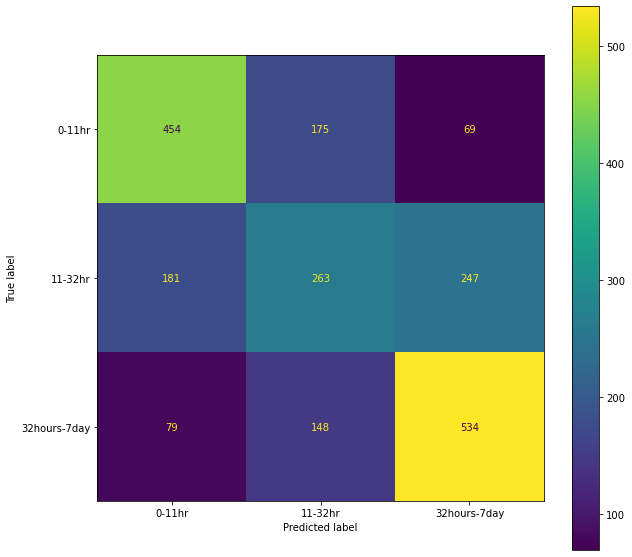

In [6]:
conmat = np.array(confusion_matrix(y_test, 
                                   randfor.predict(X_test), 
                                   labels=[0,1,2]))

print(classification_report(y_test,
                            randfor.predict(X_test), 
                            target_names=['0-11hr', '11-32hr', '32hours-7day']))

matrix_display = ConfusionMatrixDisplay(confusion_matrix=conmat, 
                                        display_labels=['0-11hr', '11-32hr', '32hours-7day'])
matrix_display.plot()

figure = plt.gcf()
figure.set_size_inches(10, 10)
;

# Feature Importance

In [7]:
randfor_importance = pd.DataFrame(data=randfor.feature_importances_, 
             columns=['importance'], 
             index=X_train.columns).sort_values(by='importance', ascending=False)

randfor_importance.head(20)

,importance
number_volunteers,0.609367
number_subjects,0.042265
aircrafts_1,0.038064
state_Pennsylvania,0.026258
winter,0.023892
daylight,0.023793
state_Utah,0.022869
state_California,0.021953
area_type_urban_rural,0.021533
area_type_wilderness,0.020467


# Analysis

**Metrics**
- Overall the model is 58% accurate in predicting the target class. This is 23% more than the baseline model with a probability of 35%. 
- The model had the most precision in predicting the third class (32hours-7days), followed closely by the 1st class (0-11hours).

**Feature Importance**
- The model gave the most importance the two continuous variables that we included `number_volunteers`, followed by `number_subjects`. The later feature was treated as a continous variabel, though it's range was limited to 1-10 subjects. 
- `aircraft_1` was the third most important feature. This dummy variable indicates that there was 1 type of aircraft used, most likely a helicopter. 
- `state_Pennsylvania` was the 4th most important feature. This state had the least number of datapoints out of all the states. These incidents were most likely all very similar. 
- `winter` was the 6th most important feature. Whether an incident occured in winter or in snow conditions has good prictive power for this model. 
- `area_type_urban_rural` and `area_type_wilderness` also were among the top 10 most important features. These features combined comprised 4% of the feature importance. 

**Conclusion**
This model is slightly more accurate in predicting the target class compared to the Logistic Regression model. Because the Logistic Regression model does have a higher level of human interpretability, I would recommend implementing the Logistic Regression model into production rather than this Random Forest Model. The Logistic Regression model also has the added benefit of incorporating Lasso, which eliminates features that mostly capture noise rather than signal. 